In [1]:
#import proper tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Access the csv files and remove the information that isn't necessary for this analysis
anne_raw = pd.read_csv('Anne.csv').drop(['Unnamed: 0'], axis=1)
sarah_raw = pd.read_csv('Sarah.csv').drop(['Unnamed: 0'], axis=1)
anne_df = anne_raw.drop(['File One','File Two'], axis=1)
sarah_df = sarah_raw.drop(['File One','File Two'], axis=1)

In [2]:
#add_confus adds columns to the dataframes that represent what kind of correct or incorrect they are
#in the style of a confusion matrix
def add_confus(mat):
    same = mat['Other Vowel'].isnull()
    diff = np.logical_not(mat['Other Vowel'].isnull())
    truth = mat['Correctness']
    falth = np.logical_not(mat['Correctness'])
    mix = lambda a,b: np.where(np.logical_and(a,b),True, False)
    mat['True Same'] = mix(same,truth)
    mat['False Same'] = mix(diff,falth)
    mat['True Different'] = mix(diff,truth)
    mat['False Different'] = mix(same,falth)

add_confus(anne_df)
add_confus(sarah_df)

In [3]:
t_types = [anne_df['Test Type'][i] for i in [1,26,51,76]]
confus = list(anne_df.columns[-4:])
def get_test_type_stats(mat):
    data = dict([])
    for t in t_types:
        temp = dict([])
        for c in confus:
            temp[c] = len( (np.where(mat[mat['Test Type']==t][c]))[0])
        data[t]=temp
    result = pd.DataFrame(data).T
    result.index.name = 'Test Type'
    return result

test_type_matrix = get_test_type_stats(anne_df)+get_test_type_stats(sarah_df)
test_type_matrix

,True Same,False Same,True Different,False Different
Test Type,,,,
BareVowel,25,0,25,0
SameCons,32,5,12,1
DiffCons,23,7,16,4
Words,8,1,29,12


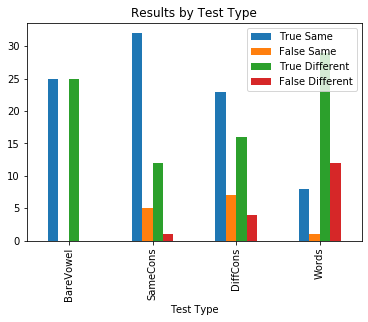

In [4]:
test_type_matrix.plot.bar(title='Results by Test Type')

In [5]:
#find_confused_vowels gets a dataframe with each pair of confused vowels and the frequency of that pair
def find_confused_vowels(mat):
    false_sames = mat[mat['False Same']==True]
    pairs = list(zip(false_sames['Vowel'],false_sames['Other Vowel']))
    for i in range(len(pairs)):
        if pairs[i][0] > pairs[i][1]:
            pairs[i] = (pairs[i][1],pairs[i][0])
    counts = {}
    for i in pairs:
        counts[i] = counts.get(i, 0) + 1
    return pd.DataFrame.from_dict(counts,orient='index')

#Then we aggregate the confusions between each listener
confused_vowels = find_confused_vowels(anne_df).append(find_confused_vowels(sarah_df))
confused_vowels.reset_index(inplace=True)
confused_vowels = confused_vowels.groupby(confused_vowels['index']).aggregate({0:'sum'})

#And then it'd be nice to have it clearly labeled and sorted
confused_vowels.index.name = "Vowels"
confused_vowels.columns = ["Times Confused"]
confused_vowels.sort_values(by='Times Confused',inplace=True,ascending=False)
confused_vowels

,Times Confused
Vowels,
"(ɛ, ɪ)",3
"(æ, ɪ)",2
"(a, eɪ)",1
"(a, ʌ)",1
"(eɪ, ɪ)",1
"(oʊ, u)",1
"(æ, ɛ)",1
"(æ, ʌ)",1
"(ɪ, ʊ)",1


In [6]:
#get_false_diff_data returns a Series containing each vowel
#and the number of times it was falsely marked as different from itself
vowels = ['a','æ','eɪ','ɛ','i','ɪ','oʊ','u','ʊ','ʌ']
def get_false_diff_data(mat):
    false_diffs = mat[mat['False Different']==True]
    false_diffs = false_diffs['Vowel'].value_counts()
    result = pd.Series([0 for i in range(len(vowels))],index=vowels)
    result += false_diffs
    return result.fillna(0).astype('int32')

false_diff_data = get_false_diff_data(anne_df) + get_false_diff_data(sarah_df)

#And then we sort it and label it
false_diff_data.sort_values(ascending=False,inplace=True)
false_diff_data.index.name = 'Vowels'
false_diff_data = pd.DataFrame(false_diff_data)
false_diff_data.columns = ['Times Confused']
false_diff_data

,Times Confused
Vowels,
ʊ,4
ʌ,2
u,2
ɪ,2
ɛ,2
eɪ,2
a,2
i,1
oʊ,0


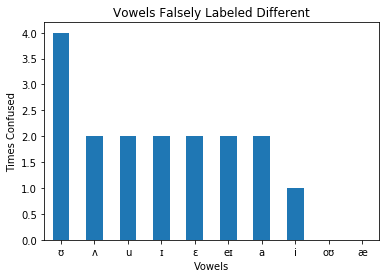

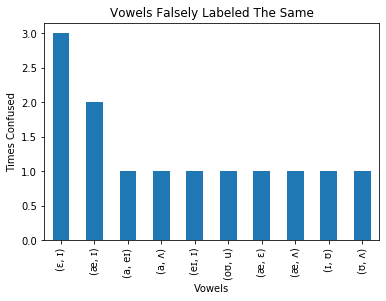

In [7]:
axs = [None,None]
axs[0] = false_diff_data.plot.bar(legend=False,title='Vowels Falsely Labeled Different')
plt.xticks(rotation='horizontal')
axs[1] = confused_vowels.plot.bar(legend=False,title='Vowels Falsely Labeled The Same')
for i in axs:
    i.set_ylabel('Times Confused')
    i.plot()

In [8]:
#Now let's analyze in terms of formants
#First, load up the formant measurements
formants = {}
for i in vowels:
    df = pd.read_csv('Vowel Formants/'+i+' formants.csv').drop('Unnamed: 0', axis=1)
    df.index = df['File']
    formants[i] = df.drop('File', axis=1)

In [9]:
#Now, we're going to get all the formant data for each type of correct/incorrect answer

#compare_formants takes a list with two vowels and two recording names
#and returns a DataFrame with a row for each recording and a row of the differences between them
def compare_formants(args):
    [v1,v2,rec1,rec2] = args
    v2 = v1 if type(v2)==type(0.1) else v2
    if v2!=v1:
        data = {}
        data[v1] = formants[v1].loc[rec1]
        data[v2] = formants[v2].loc[rec2]
        data['Differences'] = np.abs(data[v1] - data[v2])
        return pd.DataFrame(data).T
    else:
        row1 = {v1: formants[v1].loc[rec1]}
        row2 = {v2: formants[v2].loc[rec2]}
        result = pd.DataFrame(row1).T.append(pd.DataFrame(row2).T)
        result.loc['Differences'] = np.abs(result.iloc[0]-result.iloc[1])
        return result
        
#get_formant_diffs gets all the formant difference DataFrames from compare_formants for
#a particular person's data and a particular type of correct/incorrect answer
def get_formant_diffs(mat_raw,mat,confus_type):
    start = mat_raw[mat[confus_type]==True].drop(['Test Type','Correctness'],axis=1)
    data = []
    for i in range(len(start.index)):
        data.append(compare_formants(list(start.iloc[i])))
    return pd.concat(data)

getfd = lambda i: get_formant_diffs(anne_raw,anne_df,i).append(get_formant_diffs(sarah_raw,sarah_df,i))
formant_differences = [getfd(i) for i in confus]

In [10]:
true_sames = formant_differences[0]
true_sames

,F1,F2,F3
ʊ,446.734368,1879.037848,2618.457233
ʊ,449.088141,1382.682606,2827.117488
Differences,2.353773,496.355243,208.660255
eɪ,482.892249,1916.911926,2495.003712
eɪ,420.962731,1990.003836,2616.078624
...,...,...,...
ɪ,471.408238,1859.902305,2620.249795
Differences,11.625154,23.288098,159.321337
æ,629.130745,1403.061221,1870.294175
æ,592.698554,1849.083031,2573.279145


In [11]:
false_sames = formant_differences[1]
false_sames

,F1,F2,F3
ɛ,515.572416,1775.775877,2718.365807
æ,612.443391,1630.905556,2461.901065
Differences,96.870975,144.870321,256.464743
ɛ,515.572416,1775.775877,2718.365807
ɪ,457.423837,1893.682812,2810.138605
Differences,58.148579,117.906935,91.772798
æ,663.025620,1249.984673,2181.902514
ɪ,449.237974,1618.567623,2243.761852
Differences,213.787645,368.582950,61.859338
ɪ,404.352901,1816.292037,2575.728933


In [12]:
true_diffs = formant_differences[2]
true_diffs

,F1,F2,F3
ʌ,628.643811,1335.637772,2445.672216
ɪ,443.777124,1881.837542,2672.748522
Differences,184.866686,546.199769,227.076306
i,258.124019,2268.928046,3198.124924
a,799.338950,1121.237671,2835.682242
...,...,...,...
ɪ,483.033392,1836.614208,2460.928458
Differences,19.644212,673.168488,83.591145
eɪ,464.894189,1571.287326,1802.909397
ɛ,576.352814,1628.385992,2415.239600


In [13]:
false_diffs = formant_differences[3]
false_diffs

,F1,F2,F3
u,362.472216,1832.593644,2424.908777
u,387.673587,1837.815405,2588.727893
Differences,25.201371,5.221762,163.819116
ɛ,527.694699,1782.176279,2566.590856
ɛ,563.915391,1538.017191,2605.840116
Differences,36.220692,244.159088,39.249260
ʊ,448.093340,1814.923652,2949.367416
ʊ,445.342566,1335.476542,2629.003941
Differences,2.750774,479.447110,320.363475
eɪ,442.380112,1784.093832,2557.371887


In [14]:
#Is there a connection between average formant magnitude and confusion type?
formant_heights = {}
for i in range(len(formant_differences)):
    checker = formant_differences[i].drop('Differences')
    formant_heights[confus[i]] = checker.mean()
pd.DataFrame(formant_heights).T
#Not really, no

,F1,F2,F3
True Same,503.427791,1677.298617,2578.756461
False Same,525.230721,1568.985872,2561.303527
True Different,510.817117,1599.091735,2513.850159
False Different,508.858198,1571.073796,2512.380914


In [15]:
#Is there a connection between formant differences and confusion type?
just_differences = {}
for i in range(len(formant_differences)):
    checker = formant_differences[i].loc['Differences']
    just_differences[confus[i]] = checker.mean()
pd.DataFrame(just_differences).T
#Looks promising! Let's get more detail

,F1,F2,F3
True Same,30.112704,104.988122,168.788264
False Same,121.948080,251.660524,241.921538
True Different,179.544871,463.075380,346.896550
False Different,49.438788,198.189236,299.122028


In [16]:
all_differences = []
for i in range(len(formant_differences)):
    add_df = formant_differences[i][formant_differences[i].index=='Differences'].copy()
    add_df['Confusion Type'] = confus[i]
    all_differences.append(add_df)
    
all_differences = pd.concat(all_differences).reset_index().drop('index',axis=1)
for i in ['1','2','3']:
    all_differences['F'+i+' Decile'] = list(pd.qcut(all_differences['F'+i],10,range(1,11)))
deciles = all_differences.drop(['F1','F2','F3'], axis=1)
deciles

,Confusion Type,F1 Decile,F2 Decile,F3 Decile
0,True Same,1,9,7
1,True Same,6,3,4
2,True Same,1,3,2
3,True Same,5,6,4
4,True Same,2,1,3
...,...,...,...,...
195,False Different,1,8,8
196,False Different,4,4,3
197,False Different,4,4,3
198,False Different,4,8,10


In [17]:
decile_counts = {}
for i in ['F1 Decile','F2 Decile','F3 Decile']:
    formant_counter = {}
    for j in range(1,11):
        confus_counter = {}
        for k in confus:
            l = lambda d: np.logical_and( d[i]==j, d['Confusion Type']==k)
            confus_counter[k] = len(deciles.loc[l, :])
        formant_counter[j] = confus_counter
    decile_counts[i] = formant_counter

In [18]:
decile_counts['F1 Decile'] = pd.DataFrame(decile_counts['F1 Decile'])
decile_counts['F1 Decile']

,1,2,3,4,5,6,7,8,9,10
True Same,16,15,17,15,13,7,3,2,0,0
False Same,2,0,0,0,0,2,4,2,2,1
True Different,1,1,5,0,5,7,14,12,18,19
False Different,2,3,0,5,1,3,1,2,0,0


In [19]:
decile_counts['F2 Decile'] = pd.DataFrame(decile_counts['F2 Decile'])
decile_counts['F2 Decile']

,1,2,3,4,5,6,7,8,9,10
True Same,16,17,18,10,8,11,3,4,1,0
False Same,0,0,0,0,6,2,2,2,0,1
True Different,2,1,4,5,6,4,13,10,18,19
False Different,3,1,1,2,1,3,1,5,0,0


In [20]:
decile_counts['F3 Decile'] = pd.DataFrame(decile_counts['F3 Decile'])
decile_counts['F3 Decile']

,1,2,3,4,5,6,7,8,9,10
True Same,16,15,7,11,12,10,4,4,3,6
False Same,0,1,4,1,0,0,3,2,1,1
True Different,4,2,5,9,3,10,14,10,16,9
False Different,0,2,5,0,3,0,0,3,0,4


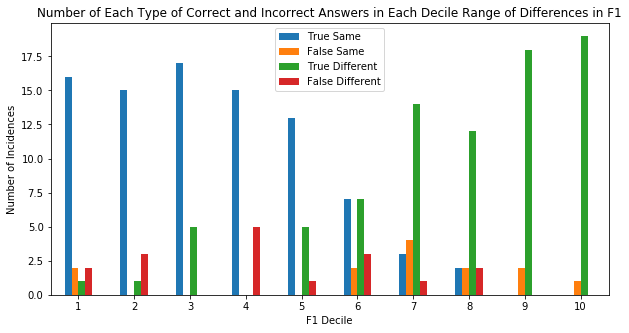

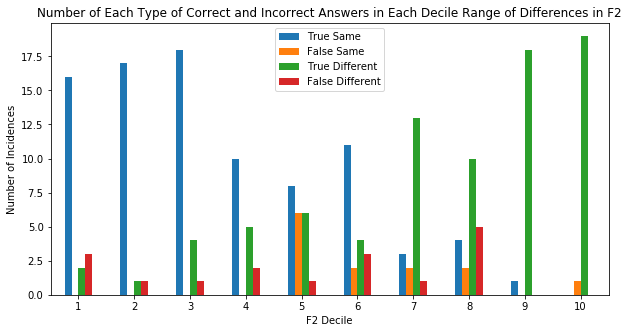

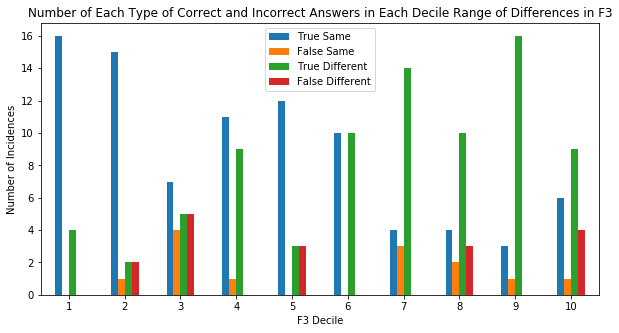

In [21]:
axs = [None,None,None]
ttl = 'Number of Each Type of Correct and Incorrect Answers in Each Decile Range of Differences in F'
titles = [ttl+i for i in ['1','2','3']]
for i in enumerate(decile_counts):
    axs[i[0]] = decile_counts[i[1]].T.plot.bar(title=titles[i[0]], figsize=(10,5))
    plt.xticks(rotation='horizontal')
    axs[i[0]].set_xlabel(i[1])
    axs[i[0]].set_ylabel('Number of Incidences')
    axs[i[0]].plot()